In [1]:
#!/usr/bin/env python
# coding: utf-8
import matplotlib.pyplot as plt
import numpy as np
import cmdstanpy

Suppose we have a particle with mass $m$ undergoing simple harmonic motion with some spring constant $k$:

$F = -kx, F=ma=m\ddot{x} \implies \ddot{x} = -k/m \cdot x$

And we are able to measure the position of the particle with some uncertainty $\sigma$ and get measurements $z_t$ at each time step $t$:

$z_t \sim \text{Normal}(x_t, \sigma)$

Initialise with an initial position and velocity, $y_0 = [x_0,\dot{x}_0]$

And we can simulate the system and generate some measurements using a Stan model for convenience:

In [2]:
y0 = [5,1]
theta = 1 # k/m
sigma = 0.5

T = 100
t0 = 0
dt = 0.1
T_max = dt*T
times = np.arange(t0, T_max, dt)
ode_times = times[1:]

gen_data = {'T': T, 't0': t0, 'theta': theta, 'times': ode_times,
           'sigma': sigma, 'y0': y0}

In [3]:
gen_model = cmdstanpy.CmdStanModel(stan_file="dataGen.stan")
sim_data = gen_model.sample(data=gen_data, fixed_param=True, iter_sampling=1,chains=1)

13:33:46 - cmdstanpy - INFO - compiling stan file /home/alecks/git/MinimalODEExample/dataGen.stan to exe file /home/alecks/git/MinimalODEExample/dataGen
13:33:52 - cmdstanpy - INFO - compiled model executable: /home/alecks/git/MinimalODEExample/dataGen
13:33:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

13:33:52 - cmdstanpy - INFO - CmdStan done processing.


Plot the resulting simulated data and simulated measurements

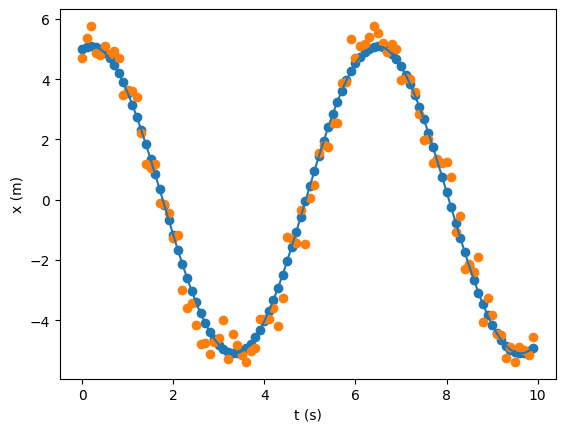

In [4]:
y = sim_data.stan_variable('y')
z = sim_data.stan_variable('z')
yp = np.reshape(y[0],[T,2])[:,0]

ax = plt.figure().add_subplot(111)
plt.scatter(times, yp)
plt.plot(times, yp)
plt.scatter(times, z)
ax.set_xlabel('t (s)')
ax.set_ylabel('x (m)')
plt.savefig('simulated_data.png')
plt.show()


Fit the simulated measurements with a Stan model 

In [5]:
data = {'T': T, 't0': t0, 'theta': theta, 'times': ode_times,
        'y0_prior_mu': [0,0], 'y0_prior_std': [10,10],
        'sigma': sigma, 'z': z[0,:]}

minimalODEModel = cmdstanpy.CmdStanModel(stan_file="minimalODEExample.stan")

sim_data = minimalODEModel.sample(data=data, iter_warmup=2000, iter_sampling=2000)

13:33:53 - cmdstanpy - INFO - compiling stan file /home/alecks/git/MinimalODEExample/minimalODEExample.stan to exe file /home/alecks/git/MinimalODEExample/minimalODEExample
13:34:02 - cmdstanpy - INFO - compiled model executable: /home/alecks/git/MinimalODEExample/minimalODEExample
13:34:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:34:03 - cmdstanpy - INFO - CmdStan done processing.


In [6]:
sim_data.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-50.856400,0.016241,1.003690,-52.863900,-50.554200,-49.889800,3819.33,1837.98,1.00012
y0_raw[1],0.509179,0.000086,0.007054,0.497565,0.509163,0.520658,6681.52,3215.36,1.00041
y0_raw[2],0.109116,0.000081,0.007227,0.097314,0.109148,0.121126,8020.66,3859.80,1.00015
y0[1],5.091790,0.000863,0.070545,4.975650,5.091630,5.206580,6681.52,3215.36,1.00041
y0[2],1.091160,0.000807,0.072267,0.973143,1.091480,1.211260,8020.66,3859.80,1.00015


Now, use the same model but this time with the ode function defined in an external C++ file (for now just using the definition that Stan previously generated):

In [7]:
minimalODEModel_externalCpp = cmdstanpy.CmdStanModel(
    stan_file="minimalODEExample-external.stan",
    user_header="odefunc.hpp"
)

sim_data = minimalODEModel_externalCpp.sample(data=data, iter_warmup=2000, iter_sampling=2000)

13:34:04 - cmdstanpy - INFO - compiling stan file /home/alecks/git/MinimalODEExample/minimalODEExample-external.stan to exe file /home/alecks/git/MinimalODEExample/minimalODEExample-external


ValueError: Failed to compile Stan model '/home/alecks/git/MinimalODEExample/minimalODEExample-external.stan'. Console:

--- Translating Stan model to C++ code ---
bin/stanc --allow-undefined --o=/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp /home/alecks/git/MinimalODEExample/minimalODEExample-external.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -include /home/alecks/git/MinimalODEExample/odefunc.hpp -x c++ -o /home/alecks/git/MinimalODEExample/minimalODEExample-external.o /home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp
In file included from stan/lib/stan_math/lib/boost_1.78.0/boost/multi_array/multi_array_ref.hpp:32,
                 from stan/lib/stan_math/lib/boost_1.78.0/boost/multi_array.hpp:34,
                 from stan/lib/stan_math/lib/boost_1.78.0/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from stan/lib/stan_math/lib/boost_1.78.0/boost/numeric/odeint.hpp:63,
                 from stan/lib/stan_math/stan/math/prim/functor/ode_rk45.hpp:9,
                 from stan/lib/stan_math/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from stan/lib/stan_math/stan/math/prim/functor.hpp:14,
                 from stan/lib/stan_math/stan/math/rev/fun.hpp:198,
                 from stan/lib/stan_math/stan/math/rev.hpp:10,
                 from stan/lib/stan_math/stan/math.hpp:19,
                 from stan/src/stan/model/model_header.hpp:4,
                 from /home/alecks/git/MinimalODEExample/odefunc.hpp:3,
                 from <command-line>:
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:180:45: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  180 |         : public boost::functional::detail::unary_function<typename unary_traits<Predicate>::argument_type,bool>
      |                                             ^~~~~~~~~~~~~~
In file included from /usr/include/c++/12.2.1/string:48,
                 from /usr/include/c++/12.2.1/bits/locale_classes.h:40,
                 from /usr/include/c++/12.2.1/bits/ios_base.h:41,
                 from /usr/include/c++/12.2.1/ios:42,
                 from /usr/include/c++/12.2.1/istream:38,
                 from /usr/include/c++/12.2.1/sstream:38,
                 from /usr/include/c++/12.2.1/complex:45,
                 from stan/lib/stan_math/lib/eigen_3.3.9/Eigen/Core:96,
                 from stan/lib/stan_math/lib/eigen_3.3.9/Eigen/Dense:1,
                 from stan/lib/stan_math/stan/math/prim/fun/Eigen.hpp:22,
                 from stan/lib/stan_math/stan/math/rev.hpp:4:
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:214:45: warning: ‘template<class _Arg1, class _Arg2, class _Result> struct std::binary_function’ is deprecated [-Wdeprecated-declarations]
  214 |         : public boost::functional::detail::binary_function<
      |                                             ^~~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:131:12: note: declared here
  131 |     struct binary_function
      |            ^~~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:252:45: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  252 |         : public boost::functional::detail::unary_function<
      |                                             ^~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:299:45: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  299 |         : public boost::functional::detail::unary_function<
      |                                             ^~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:345:57: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  345 |     class mem_fun_t : public boost::functional::detail::unary_function<T*, S>
      |                                                         ^~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:361:58: warning: ‘template<class _Arg1, class _Arg2, class _Result> struct std::binary_function’ is deprecated [-Wdeprecated-declarations]
  361 |     class mem_fun1_t : public boost::functional::detail::binary_function<T*, A, S>
      |                                                          ^~~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:131:12: note: declared here
  131 |     struct binary_function
      |            ^~~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:377:63: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  377 |     class const_mem_fun_t : public boost::functional::detail::unary_function<const T*, S>
      |                                                               ^~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:393:64: warning: ‘template<class _Arg1, class _Arg2, class _Result> struct std::binary_function’ is deprecated [-Wdeprecated-declarations]
  393 |     class const_mem_fun1_t : public boost::functional::detail::binary_function<const T*, A, S>
      |                                                                ^~~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:131:12: note: declared here
  131 |     struct binary_function
      |            ^~~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:438:61: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  438 |     class mem_fun_ref_t : public boost::functional::detail::unary_function<T&, S>
      |                                                             ^~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:454:62: warning: ‘template<class _Arg1, class _Arg2, class _Result> struct std::binary_function’ is deprecated [-Wdeprecated-declarations]
  454 |     class mem_fun1_ref_t : public boost::functional::detail::binary_function<T&, A, S>
      |                                                              ^~~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:131:12: note: declared here
  131 |     struct binary_function
      |            ^~~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:470:67: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  470 |     class const_mem_fun_ref_t : public boost::functional::detail::unary_function<const T&, S>
      |                                                                   ^~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:487:68: warning: ‘template<class _Arg1, class _Arg2, class _Result> struct std::binary_function’ is deprecated [-Wdeprecated-declarations]
  487 |     class const_mem_fun1_ref_t : public boost::functional::detail::binary_function<const T&, A, S>
      |                                                                    ^~~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:131:12: note: declared here
  131 |     struct binary_function
      |            ^~~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:533:73: warning: ‘template<class _Arg, class _Result> struct std::unary_function’ is deprecated [-Wdeprecated-declarations]
  533 |     class pointer_to_unary_function : public boost::functional::detail::unary_function<Arg,Result>
      |                                                                         ^~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:117:12: note: declared here
  117 |     struct unary_function
      |            ^~~~~~~~~~~~~~
stan/lib/stan_math/lib/boost_1.78.0/boost/functional.hpp:557:74: warning: ‘template<class _Arg1, class _Arg2, class _Result> struct std::binary_function’ is deprecated [-Wdeprecated-declarations]
  557 |     class pointer_to_binary_function : public boost::functional::detail::binary_function<Arg1,Arg2,Result>
      |                                                                          ^~~~~~~~~~~~~~~
/usr/include/c++/12.2.1/bits/stl_function.h:131:12: note: declared here
  131 |     struct binary_function
      |            ^~~~~~~~~~~~~~~
/home/alecks/git/MinimalODEExample/odefunc.hpp:4:28: error: expected ‘{’ before ‘-’ token
    4 | namespace minimalODEExample-external_model_namespace {
      |                            ^
/home/alecks/git/MinimalODEExample/odefunc.hpp:4:28: error: expected unqualified-id before ‘-’ token
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In member function ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:32: error: there are no arguments to ‘odefunc_variadic2_functor__’ that depend on a template parameter, so a declaration of ‘odefunc_variadic2_functor__’ must be available [-fpermissive]
  249 |           stan::math::ode_rk45(odefunc_variadic2_functor__(), y0, t0, times,
      |                                ^~~~~~~~~~~~~~~~~~~~~~~~~~~
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:32: note: (if you use ‘-fpermissive’, G++ will accept your code, but allowing the use of an undeclared name is deprecated)
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; VecR = Eigen::Matrix<double, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; T_ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:93:80:   required from ‘double stan::model::model_base_crtp<M>::log_prob(Eigen::VectorXd&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; Eigen::VectorXd = Eigen::Matrix<double, -1, 1>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:91:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
  249 |           stan::math::ode_rk45(odefunc_variadic2_functor__(), y0, t0, times,
      |                                ~~~~~~~~~~~~~~~~~~~~~~~~~~~^~
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; VecR = Eigen::Matrix<stan::math::var_value<double>, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; T_ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:98:72:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob(Eigen::Matrix<stan::math::var_value<double>, -1, 1>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:96:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; VecR = Eigen::Matrix<double, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; T_ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:104:71:   required from ‘double stan::model::model_base_crtp<M>::log_prob_jacobian(Eigen::VectorXd&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; Eigen::VectorXd = Eigen::Matrix<double, -1, 1>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:102:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; VecR = Eigen::Matrix<stan::math::var_value<double>, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; T_ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:109:71:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob_jacobian(Eigen::Matrix<stan::math::var_value<double>, -1, 1>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:107:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; VecR = Eigen::Matrix<double, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; T_ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:115:71:   required from ‘double stan::model::model_base_crtp<M>::log_prob_propto(Eigen::VectorXd&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; Eigen::VectorXd = Eigen::Matrix<double, -1, 1>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:113:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; VecR = Eigen::Matrix<stan::math::var_value<double>, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; T_ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:120:71:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob_propto(Eigen::Matrix<stan::math::var_value<double>, -1, 1>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:118:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; VecR = Eigen::Matrix<double, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; T_ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:126:70:   required from ‘double stan::model::model_base_crtp<M>::log_prob_propto_jacobian(Eigen::VectorXd&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; Eigen::VectorXd = Eigen::Matrix<double, -1, 1>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:124:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; VecR = Eigen::Matrix<stan::math::var_value<double>, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:471:49:   required from ‘T_ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; T_ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:132:70:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob_propto_jacobian(Eigen::Matrix<stan::math::var_value<double>, -1, 1>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:129:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; VecR = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; T__ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:149:72:   required from ‘double stan::model::model_base_crtp<M>::log_prob(std::vector<double, std::allocator<double> >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:147:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; VecR = std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; T__ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:155:72:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob(std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:152:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; VecR = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; T__ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:162:71:   required from ‘double stan::model::model_base_crtp<M>::log_prob_jacobian(std::vector<double, std::allocator<double> >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:159:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; VecR = std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = true; T__ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:168:71:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob_jacobian(std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:165:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; VecR = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; T__ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:175:71:   required from ‘double stan::model::model_base_crtp<M>::log_prob_propto(std::vector<double, std::allocator<double> >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:172:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; VecR = std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = false; T__ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:181:71:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob_propto(std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:178:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; VecR = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; T__ = double; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:188:70:   required from ‘double stan::model::model_base_crtp<M>::log_prob_propto_jacobian(std::vector<double, std::allocator<double> >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:185:17:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp: In instantiation of ‘stan::scalar_type_t<T2> minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; VecR = std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >; VecI = std::vector<int>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::scalar_type_t<T2> = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’:
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:478:49:   required from ‘T__ minimalODEExample_external_model_namespace::minimalODEExample_external_model::log_prob(std::vector<T_l>&, std::vector<int>&, std::ostream*) const [with bool propto__ = true; bool jacobian__ = true; T__ = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:194:70:   required from ‘stan::math::var stan::model::model_base_crtp<M>::log_prob_propto_jacobian(std::vector<stan::math::var_value<double>, std::allocator<stan::math::var_value<double> > >&, std::vector<int>&, std::ostream*) const [with M = minimalODEExample_external_model_namespace::minimalODEExample_external_model; stan::math::var = stan::math::var_value<double>; std::ostream = std::basic_ostream<char>]’
stan/src/stan/model/model_base_crtp.hpp:191:20:   required from here
/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope
make: *** [make/program:58: /home/alecks/git/MinimalODEExample/minimalODEExample-external] Error 1

Command ['make', 'STANCFLAGS+=--allow-undefined', 'USER_HEADER=/home/alecks/git/MinimalODEExample/odefunc.hpp', '/home/alecks/git/MinimalODEExample/minimalODEExample-external']
	error during processing No such file or directory


The generated C++ gives the following error:
`/home/alecks/git/MinimalODEExample/minimalODEExample-external.hpp:249:59: error: ‘odefunc_variadic2_functor__’ was not declared in this scope`